## Initial

### Libraries

In [1]:
import pandas as pd
import fastparquet
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import faiss
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from tqdm import tqdm
import zipfile
from sentence_transformers import SentenceTransformer
import pickle
from collections import defaultdict
import pprint
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from surprise import Dataset, Reader, SVD
from surprise.model_selection import GridSearchCV
from surprise import accuracy
from sklearn.decomposition import PCA
from itertools import product
from scipy.sparse import lil_matrix
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


c:\Users\Chandler\Downloads\Misty\Recsys\recsys-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data

In [2]:
with zipfile.ZipFile(r'C:\Users\Chandler\Downloads\Misty\Recsys\user_interactions_dataset_v3.zip', 'r') as z:
    with z.open('user_interactions_dataset_v3.csv') as f:
        user_interactions1 = pd.read_csv(f)
        user_interactions1.to_parquet('user_interactions_dataset_v3_p.parquet', index=False, engine="fastparquet")

In [3]:
uinteractions1=pd.read_parquet(r'C:\Users\Chandler\Downloads\Misty\Recsys\user_interactions_dataset_v3_p.parquet', engine="fastparquet")

In [4]:
uinteractions1.head()

,user_id,book_id,title,authors,original_publication_year,rating,ratings_count,average_rating,language_code,small_image_url,cluster,top_15_tags,content,processed_text
0,2886,1,"The Hunger Games (The Hunger Games, #1)",Suzanne Collins,2008.0,5,4780653,4.34,eng,https://images.gr-assets.com/books/1447303603s...,0,"['favorites', 'currently-reading', 'young-adul...","The Hunger Games (The Hunger Games, #1) Suzann...",hunger games hunger games suzanne collins favo...
1,6158,1,"The Hunger Games (The Hunger Games, #1)",Suzanne Collins,2008.0,5,4780653,4.34,eng,https://images.gr-assets.com/books/1447303603s...,0,"['favorites', 'currently-reading', 'young-adul...","The Hunger Games (The Hunger Games, #1) Suzann...",hunger games hunger games suzanne collins favo...
2,3991,1,"The Hunger Games (The Hunger Games, #1)",Suzanne Collins,2008.0,4,4780653,4.34,eng,https://images.gr-assets.com/books/1447303603s...,0,"['favorites', 'currently-reading', 'young-adul...","The Hunger Games (The Hunger Games, #1) Suzann...",hunger games hunger games suzanne collins favo...
3,5281,1,"The Hunger Games (The Hunger Games, #1)",Suzanne Collins,2008.0,5,4780653,4.34,eng,https://images.gr-assets.com/books/1447303603s...,0,"['favorites', 'currently-reading', 'young-adul...","The Hunger Games (The Hunger Games, #1) Suzann...",hunger games hunger games suzanne collins favo...
4,5721,1,"The Hunger Games (The Hunger Games, #1)",Suzanne Collins,2008.0,5,4780653,4.34,eng,https://images.gr-assets.com/books/1447303603s...,0,"['favorites', 'currently-reading', 'young-adul...","The Hunger Games (The Hunger Games, #1) Suzann...",hunger games hunger games suzanne collins favo...


In [5]:
uinteractions1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5976479 entries, 0 to 5976478
Data columns (total 14 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   user_id                    int64  
 1   book_id                    int64  
 2   title                      object 
 3   authors                    object 
 4   original_publication_year  float64
 5   rating                     int64  
 6   ratings_count              int64  
 7   average_rating             float64
 8   language_code              object 
 9   small_image_url            object 
 10  cluster                    int64  
 11  top_15_tags                object 
 12  content                    object 
 13  processed_text             object 
dtypes: float64(2), int64(5), object(7)
memory usage: 638.4+ MB


In [6]:
clus_sim=pd.read_csv(r'C:\Users\Chandler\Downloads\Misty\Recsys\cluster_similarity.csv')

In [7]:
clus_sim

,Unnamed: 0,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5
0,Cluster_0,1.000000,0.747826,0.436782,0.715909,0.459770,0.390805
1,Cluster_1,0.747826,1.000000,0.333333,0.561404,0.350877,0.298246
2,Cluster_2,0.436782,0.333333,1.000000,0.569231,0.857143,0.846154
3,Cluster_3,0.715909,0.561404,0.569231,1.000000,0.625000,0.531250
4,Cluster_4,0.459770,0.350877,0.857143,0.625000,1.000000,0.850000
5,Cluster_5,0.390805,0.298246,0.846154,0.531250,0.850000,1.000000


### Embeddings 

In [8]:
'''aggregation'''

book_items = (
    user_interactions1
    .groupby("book_id")
    .agg({
        "title": "first",
        "authors": "first",
        "processed_text": "first",
        "cluster": "first",
        "average_rating": "first",
        "ratings_count": "first",
        "top_15_tags": "first"
    })
    .reset_index()
)

print("Unique books:", book_items.shape[0])  

book_items.to_parquet("book_items.parquet", index=False, engine='fastparquet')


Unique books: 10000


In [9]:
'''sbert embeddings'''

book_items = pd.read_parquet(r"C:\Users\Chandler\Downloads\Misty\Recsys\book_items.parquet", engine='fastparquet')

model = SentenceTransformer("multi-qa-MiniLM-L6-cos-v1")

texts = book_items["processed_text"].fillna("").tolist()

embeddings = model.encode(
    texts,
    batch_size=64,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True
)

book_items["embedding"] = list(embeddings)


with open("book_embedding_sbert.pkl", "wb") as f:
    pickle.dump(book_items, f)

print("Saved book data with embeddings. Shape:", embeddings.shape)

Batches: 100%|██████████| 157/157 [00:13<00:00, 11.27it/s]


Saved book data with embeddings. Shape: (10000, 384)


In [10]:
book_items.head(3)

,book_id,title,authors,processed_text,cluster,average_rating,ratings_count,top_15_tags,embedding
0,1,"The Hunger Games (The Hunger Games, #1)",Suzanne Collins,hunger games hunger games suzanne collins favo...,0,4.34,4780653,"['favorites', 'currently-reading', 'young-adul...","[-0.067183666, -0.090056926, -0.0014527525, -0..."
1,2,Harry Potter and the Sorcerer's Stone (Harry P...,"J.K. Rowling, Mary GrandPré",harry potter sorcerer stone harry potter rowli...,5,4.44,4602479,"['to-read', 'favorites', 'fantasy', 'currently...","[-0.09220984, -0.043249294, -0.017161835, 0.03..."
2,3,"Twilight (Twilight, #1)",Stephenie Meyer,twilight twilight stephenie meyer young adult ...,1,3.57,3866839,"['young-adult', 'fantasy', 'favorites', 'vampi...","[-0.027345534, -0.04370668, -0.040940154, 0.04..."


In [11]:
np.array(book_items['embedding'].tolist()).shape

(10000, 384)

### Faiss Index

In [12]:
with open(r"C:\Users\Chandler\Downloads\Misty\Recsys\book_embedding_sbert.pkl", "rb") as f:
    book_items = pickle.load(f)

embeddings = np.array(book_items["embedding"].tolist(), dtype=np.float32)
print("Embeddings shape:", embeddings.shape)  

dimension = embeddings.shape[1]
index = faiss.IndexFlatIP(dimension)  
index.add(embeddings)
print("FAISS index built. Number of vectors:", index.ntotal)

faiss.write_index(index, "book_faiss.index")
print("FAISS index saved.")


# D, I = index.search(embeddings[0:1], 6)  
# print("Similar book indices:", I[0][1:])
# print("Scores:", D[0][1:])

Embeddings shape: (10000, 384)
FAISS index built. Number of vectors: 10000
FAISS index saved.


## Main Function

### Loading...

In [13]:
def load_books_and_index(embedding_path, faiss_index_path):
    with open(embedding_path, "rb") as f:
        book_items = pickle.load(f)
    
    embeddings = np.array(book_items["embedding"].tolist(), dtype=np.float32)
    dimension = embeddings.shape[1]
    
    index = faiss.read_index(faiss_index_path)
    
    return book_items, embeddings, index, dimension

In [14]:
def load_sbert_model(model_name="multi-qa-MiniLM-L6-cos-v1"):
    return SentenceTransformer(model_name)

### Query-Book 

In [15]:
def search_books(query, book_items, index, model, top_k=5):
    """
    Given a query string, return top_k books from FAISS index.
    """
    query_vec = model.encode([query], convert_to_numpy=True, normalize_embeddings=True).astype(np.float32)
    D, I = index.search(query_vec, top_k)
    
    results = []
    for i, score in zip(I[0], D[0]):
        book = book_items.iloc[i]
        results.append({
            "book_id": book["book_id"],
            "title": book["title"],
            "authors": book["authors"],
            "similarity": float(score),
            "average_rating": book["average_rating"]
        })
    return pd.DataFrame(results)

### Book-book 

In [16]:
def recommend_similar_books(book_id, book_items, embeddings, index, k=5):
    """
    Given a book_id, return top k most similar books using FAISS.
    """
    try:
        idx = book_items[book_items["book_id"] == book_id].index[0]
    except IndexError:
        return pd.DataFrame()
    
    query_vector = embeddings[idx].reshape(1, -1)
    D, I = index.search(query_vector, k + 1)
    
    neighbors = [(i, d) for i, d in zip(I[0], D[0]) if i != idx][:k]
    
    results = []
    for i, score in neighbors:
        book = book_items.iloc[i]
        results.append({
            "book_id": book["book_id"],
            "title": book["title"],
            "authors": book["authors"],
            "similarity": float(score),
            "average_rating": book["average_rating"]
        })
    return pd.DataFrame(results)

### By title

In [17]:
def recommend_by_title(title, book_items, embeddings, index, k=5):
    """
    Given a book title, recommend top k similar books.
    """
    try:
        book_id = book_items[book_items["title"].str.lower() == title.lower()]["book_id"].values[0]
    except IndexError:
        print(f"Book title '{title}' not found!")
        return pd.DataFrame()
    
    return recommend_similar_books(book_id, book_items, embeddings, index, k=k)

### '''Pipeline'''

In [18]:
def blended_recommendations(input_text, book_items, embeddings, index, model,
                            top_k_query=5, top_k_book2book=3,
                            alpha=0.7, beta=0.1):
    """
    input_text: can be either a query string or a book title.
    top_k_query: number of top books from query search
    top_k_book2book: number of similar books per query match
    alpha: weight for query relevance
    beta: weight for rating boost
    """

    matches = book_items[book_items["title"].str.lower() == input_text.lower()]
    if not matches.empty:
        book_id = matches["book_id"].values[0]
        print(f"Interpreting input as book title: '{input_text}' (book_id={book_id})")
        query_df = recommend_similar_books(book_id, book_items, embeddings, index, k=top_k_query)
    else:
        print(f"Interpreting input as query: '{input_text}'")
        query_df = search_books(input_text, book_items, index, model, top_k=top_k_query)


    all_candidates = []
    for book_id in query_df["book_id"]:
        sim_df = recommend_similar_books(book_id, book_items, embeddings, index, k=top_k_book2book)
        all_candidates.append(sim_df)

    if all_candidates:
        candidates = pd.concat(all_candidates, ignore_index=True)
        candidates = pd.concat([query_df, candidates], ignore_index=True)
        candidates = candidates.groupby("book_id").agg({
            "title": "first",
            "authors": "first",
            "similarity": "max",
            "average_rating": "first"
        }).reset_index()

        rating_score = (candidates["average_rating"] - candidates["average_rating"].min()) / (
                        candidates["average_rating"].max() - candidates["average_rating"].min() + 1e-6)
        candidates["final_score"] = alpha * candidates["similarity"] + beta * rating_score

        candidates = candidates.sort_values("final_score", ascending=False)
        return candidates
    else:
        return query_df

In [19]:
if __name__ == "__main__":
    book_items, embeddings, index, dimension = load_books_and_index(
        r"C:\Users\Chandler\Downloads\Misty\Recsys\book_embedding_sbert.pkl",
        r"C:\Users\Chandler\Downloads\Misty\Recsys\book_faiss.index"
    )
    model = load_sbert_model()

### Sample_Test

In [20]:
search_books("dark fantasy adventure with dragons", book_items, index, model, top_k=5)

,book_id,title,authors,similarity,average_rating
0,1869,Dealing with Dragons (Enchanted Forest Chronic...,"Patricia C. Wrede, Peter de Sève",0.677226,4.14
1,9618,"Dragon Actually (Dragon Kin, #1)",G.A. Aiken,0.666480,3.96
2,4985,Talking to Dragons (Enchanted Forest Chronicle...,"Patricia C. Wrede, Peter de Sève",0.654445,4.19
3,4396,Calling on Dragons (Enchanted Forest Chronicle...,"Patricia C. Wrede, Peter de Sève",0.650289,4.20
4,8729,"Dragon Prince (Dragon Prince, #1)",Melanie Rawn,0.633496,3.94


In [21]:
recommend_similar_books(1, book_items, embeddings, index, k=5)

,book_id,title,authors,similarity,average_rating
0,20,"Mockingjay (The Hunger Games, #3)",Suzanne Collins,0.947055,4.03
1,507,The Hunger Games Trilogy Boxset (The Hunger Ga...,Suzanne Collins,0.929299,4.49
2,17,"Catching Fire (The Hunger Games, #2)",Suzanne Collins,0.898523,4.30
3,6224,The World of the Hunger Games (Hunger Games Tr...,Kate Egan,0.858265,4.48
4,8577,The Girl Who Was on Fire: Your Favorite Author...,"Leah Wilson, Jennifer Lynn Barnes, Mary Borsel...",0.798373,4.28


In [22]:
recommend_by_title("The Hobbit", book_items, embeddings, index, k=5)

,book_id,title,authors,similarity,average_rating
0,2309,The Children of Húrin,"J.R.R. Tolkien, Christopher Tolkien, Alan Lee",0.834491,3.94
1,155,"The Two Towers (The Lord of the Rings, #2)",J.R.R. Tolkien,0.826510,4.42
2,161,"The Return of the King (The Lord of the Rings,...",J.R.R. Tolkien,0.820656,4.51
3,189,"The Lord of the Rings (The Lord of the Rings, ...",J.R.R. Tolkien,0.811062,4.47
4,19,The Fellowship of the Ring (The Lord of the Ri...,J.R.R. Tolkien,0.806949,4.34


In [23]:
blended_recommendations("dark fantasy adventure with dragons", book_items, embeddings, index, model)

Interpreting input as query: 'dark fantasy adventure with dragons'


,book_id,title,authors,similarity,average_rating,final_score
1,3860,Searching for Dragons (Enchanted Forest Chroni...,"Patricia C. Wrede, Peter de Sève",0.958830,4.25,0.771181
3,4396,Calling on Dragons (Enchanted Forest Chronicle...,"Patricia C. Wrede, Peter de Sève",0.959468,4.20,0.758807
4,4985,Talking to Dragons (Enchanted Forest Chronicle...,"Patricia C. Wrede, Peter de Sève",0.959468,4.19,0.756243
0,1869,Dealing with Dragons (Enchanted Forest Chronic...,"Patricia C. Wrede, Peter de Sève",0.935065,4.14,0.726340
5,5566,"Dragon Bound (Elder Races, #1)",Thea Harrison,0.805394,4.13,0.633007
7,7502,"Dragon Flight (Dragon Slippers, #2)",Jessica Day George,0.754929,4.18,0.610501
2,4125,"The Dragon Heir (The Heir Chronicles, #3)",Cinda Williams Chima,0.763172,4.14,0.606015
6,5883,"Icefire (The Last Dragon Chronicles, #2)",Chris d'Lacey,0.777974,3.90,0.554839
9,9077,The Last Dragonslayer (The Chronicles of Kazam...,Jasper Fforde,0.750295,3.86,0.525206
10,9618,"Dragon Actually (Dragon Kin, #1)",G.A. Aiken,0.666480,3.96,0.492177


### Complete Function

In [24]:
def core_recommender(query_vec, book_items, embeddings, index,
                     top_k_query=10, expand_k=5,
                     alpha=0.5, beta=0.9, gamma=0.0,
                     clusters=None, diversity=False,
                     exclude_idxs=None):
    """
    Core recommender logic (query → FAISS search → expansion → scoring).
    
    query_vec: np.ndarray, shape (1, dim) normalized query vector
    exclude_idxs: indices to exclude (e.g., user’s train books)
    """
    Dq, Iq = index.search(query_vec, top_k_query)
    query_idxs = Iq[0].tolist()
    query_scores = Dq[0].tolist()

    candidates = pd.DataFrame({"idx": query_idxs, "query_score": query_scores})

    sim_idxs, sim_scores = [], []
    for qidx in query_idxs:
        vec = embeddings[qidx].reshape(1, -1).astype(np.float32)
        faiss.normalize_L2(vec)
        Ds, Is = index.search(vec, expand_k + 1)  
        for s_val, s_idx in zip(Ds[0][1:], Is[0][1:]):  
            sim_idxs.append(int(s_idx))
            sim_scores.append(float(s_val))

    if sim_idxs:
        sim_df = pd.DataFrame({"idx": sim_idxs, "similarity_score": sim_scores})
        candidates = pd.concat([candidates, sim_df], ignore_index=True)

    agg = candidates.groupby("idx").agg({
        "query_score": "max",
        "similarity_score": "max"
    }).reset_index()
    agg = agg.fillna(0.0)

    ratings = book_items.iloc[agg["idx"]]["average_rating"].values
    if np.nanmax(ratings) - np.nanmin(ratings) > 1e-9:
        rating_score = (ratings - np.nanmin(ratings)) / (np.nanmax(ratings) - np.nanmin(ratings))
    else:
        rating_score = np.zeros_like(ratings)

    if diversity and clusters is not None:
        seen = set()
        penalty = []
        for idx in agg["idx"]:
            c = clusters[idx]
            if c in seen:
                penalty.append(1.0)
            else:
                penalty.append(0.0)
                seen.add(c)
        penalty = np.array(penalty)
    else:
        penalty = np.zeros(len(agg))

    agg["final_score"] = (
        alpha * agg["query_score"].values +        
        beta * agg["similarity_score"].values +   
        (1 - alpha - beta) * rating_score -       
        gamma * penalty 
    )                          

    if exclude_idxs is not None and len(exclude_idxs) > 0:
        agg = agg[~agg["idx"].isin(exclude_idxs)]

    results = agg.merge(book_items.reset_index()[["index", "book_id", "title", "authors", "average_rating"]],
                        left_on="idx", right_on="index", how="left")
    results = results.sort_values("final_score", ascending=False).reset_index(drop=True)

    return results


def recommend_from_query(query, model, book_items, embeddings, index, **kwargs):
    query_vec = model.encode([query], convert_to_numpy=True, normalize_embeddings=True).astype(np.float32)
    faiss.normalize_L2(query_vec)
    return core_recommender(query_vec, book_items, embeddings, index, **kwargs)


def recommend_from_title(title, book_items, embeddings, index, model=None, **kwargs):
    """
    Recommend books based on a given book title.
    If the title is missing, falls back to using the book's processed text.
    """
    matches = book_items[book_items["title"].str.lower() == title.lower()]
    
    if not matches.empty:
        book_idx = matches.index[0]
        query_vec = embeddings[book_idx].reshape(1, -1).astype(np.float32)
        faiss.normalize_L2(query_vec)
        return core_recommender(query_vec, book_items, embeddings, index, **kwargs)
    
    text_matches = book_items[book_items["title"].str.lower() == title.lower()]["processed_text"]
    if not text_matches.empty and model is not None:
        query_vec = model.encode([text_matches.values[0]], convert_to_numpy=True, normalize_embeddings=True).astype(np.float32)
        faiss.normalize_L2(query_vec)
        return core_recommender(query_vec, book_items, embeddings, index, **kwargs)
    print(f"Book title '{title}' not found and no fallback available!")
    return pd.DataFrame()



def recommend_from_user_history(user_book_ids, book_items, embeddings, index,
                                rating_weight=0.5, popularity_weight=0.5,
                                **kwargs):
    """
    Weighted user-history embedding:
    - rating_weight: importance of user's rating
    - popularity_weight: importance of book popularity
    """
    valid_idxs = [book_items.index[book_items["book_id"] == b][0] 
                  for b in user_book_ids if b in book_items["book_id"].values]
    if not valid_idxs:
        return pd.DataFrame()
    
    ratings = book_items.iloc[valid_idxs]["average_rating"].values
    popularity = book_items.iloc[valid_idxs]["ratings_count"].values.astype(np.float32)
    
    ratings_norm = (ratings - ratings.min()) / (ratings.max() - ratings.min() + 1e-6)
    popularity_norm = (popularity - popularity.min()) / (popularity.max() - popularity.min() + 1e-6)
    
    weights = rating_weight * ratings_norm + popularity_weight * popularity_norm
    weights = weights / weights.sum()  

    weighted_vec = np.average(embeddings[valid_idxs], axis=0, weights=weights)
    weighted_vec = weighted_vec.reshape(1, -1).astype(np.float32)
    faiss.normalize_L2(weighted_vec)
    
    return core_recommender(weighted_vec, book_items, embeddings, index, exclude_idxs=valid_idxs, **kwargs)


In [25]:
user_history = [1, 6, 5]  
recs = recommend_from_user_history(user_history, book_items, embeddings, index, top_k_query=10, expand_k=5)
recs.head(10)


,idx,query_score,similarity_score,final_score,index,book_id,title,authors,average_rating
0,19,0.911928,0.947055,1.199223,19,20,"Mockingjay (The Hunger Games, #3)",Suzanne Collins,4.03
1,16,0.869930,0.898523,0.970909,16,17,"Catching Fire (The Hunger Games, #2)",Suzanne Collins,4.30
2,506,0.882247,0.929299,0.889613,506,507,The Hunger Games Trilogy Boxset (The Hunger Ga...,Suzanne Collins,4.49
3,8576,0.791116,0.815319,0.868739,8576,8577,The Girl Who Was on Fire: Your Favorite Author...,"Leah Wilson, Jennifer Lynn Barnes, Mary Borsel...",4.28
4,6223,0.833708,0.886783,0.833140,6223,6224,The World of the Hunger Games (Hunger Games Tr...,Kate Egan,4.48
5,1354,0.764552,0.839802,0.804765,1354,1355,The Hunger Games Tribute Guide,Emily Seife,4.40
6,716,0.763431,0.886783,0.779820,716,717,The Hunger Games: Official Illustrated Movie C...,Kate Egan,4.51
7,684,0.000000,0.808048,0.727243,684,685,"Gone (Gone, #1)",Michael Grant,3.85
8,2264,0.000000,0.824546,0.596637,2264,2265,"Lies (Gone, #3)",Michael Grant,4.09
9,2844,0.000000,0.757615,0.481853,2844,2845,"Plague (Gone, #4)",Michael Grant,4.18


In [26]:
def make_leave_one_out(interactions):
    """
    For each user, hold out 1 item for testing, keep the rest for training.
    Only keep users with at least 2 positive interactions.
    """
    interactions = interactions[interactions["rating"] >= 4]

    train_by_user = defaultdict(list)
    test_by_user = defaultdict(list)

    for user, group in interactions.groupby("user_id"):
        if len(group) < 2:
            continue  
        held_out = group.sample(1, random_state=42)
        train = group.drop(held_out.index)

        train_by_user[user] = train["book_id"].tolist()
        test_by_user[user] = held_out["book_id"].tolist()

    return train_by_user, test_by_user


def evaluate_all_recommenders(interactions, book_items, embeddings, index, model, 
                              k=10, max_users=None):
    """
    Evaluate query-based, book-to-book, and user-history recommenders 
    using Leave-One-Out evaluation.
    """
    train_by_user, test_by_user = make_leave_one_out(interactions)

    users = list(test_by_user.keys())
    if max_users:
        users = pd.Series(users).sample(n=max_users, random_state=42).tolist()

    metrics = {
        "query": {"precision": [], "recall": [], "ndcg": []},
        "book2book": {"precision": [], "recall": [], "ndcg": []},
        "user": {"precision": [], "recall": [], "ndcg": []},
    }

    for user in tqdm(users, desc="Evaluating users", unit="user"):
        user_history = train_by_user[user]
        held_out = test_by_user[user][0]

        if not user_history:
            continue

        # ---- (1) User-history recommender ----
        recs_user = recommend_from_user_history(user_history, book_items, embeddings, index, top_k_query=k)
        
        # ---- (2) Book-to-book recommender ----
        recs_b2b = recommend_from_title(
            title=book_items.loc[book_items["book_id"] == user_history[0], "title"].values[0],
            book_items=book_items, embeddings=embeddings, index=index, model=model, top_k_query=k
        )

        # ---- (3) Query recommender ----
        query_text = book_items.loc[book_items["book_id"] == held_out, "processed_text"].values[0]
        recs_query = recommend_from_query(query_text, model, book_items, embeddings, index, top_k_query=k)

        for mode, recs in [("user", recs_user), ("book2book", recs_b2b), ("query", recs_query)]:
            if recs.empty:
                continue

            recommended_ids = recs["book_id"].head(k).tolist()
            hit = int(held_out in recommended_ids)

            precision = hit / k
            recall = hit / 1  
            if hit:
                rank = recommended_ids.index(held_out) + 1
                ndcg = 1 / np.log2(rank + 1)
            else:
                ndcg = 0

            metrics[mode]["precision"].append(precision)
            metrics[mode]["recall"].append(recall)
            metrics[mode]["ndcg"].append(ndcg)

    final_metrics = {
        mode: {
            "Precision@K": float(np.mean(vals["precision"])) if vals["precision"] else 0,
            "Recall@K": float(np.mean(vals["recall"])) if vals["recall"] else 0,
            "NDCG@K": float(np.mean(vals["ndcg"])) if vals["ndcg"] else 0,
            "Users_evaluated": len(vals["precision"])
        }
        for mode, vals in metrics.items()
    }

    return final_metrics

In [27]:
metrics = evaluate_all_recommenders(
    interactions=user_interactions1,
    book_items=book_items,
    embeddings=embeddings,
    index=index,
    model=model,   
    k=10,
    max_users=500  
)

pprint.pprint(metrics)

Evaluating users: 100%|██████████| 500/500 [00:18<00:00, 27.72user/s]

{'book2book': {'NDCG@K': 0.012836159475841132,
               'Precision@K': 0.0024000000000000002,
               'Recall@K': 0.024,
               'Users_evaluated': 500},
 'query': {'NDCG@K': 0.6079379312507023,
           'Precision@K': 0.0908,
           'Recall@K': 0.908,
           'Users_evaluated': 500},
 'user': {'NDCG@K': 0.02173071731364285,
          'Precision@K': 0.0034068136272545095,
          'Recall@K': 0.03406813627254509,
          'Users_evaluated': 499}}


## Memory based CF

### User-User

In [28]:
print(uinteractions1['user_id'].nunique())
print(uinteractions1.columns)

53424
Index(['user_id', 'book_id', 'title', 'authors', 'original_publication_year',
       'rating', 'ratings_count', 'average_rating', 'language_code',
       'small_image_url', 'cluster', 'top_15_tags', 'content',
       'processed_text'],
      dtype='object')


In [29]:
user_ids = user_interactions1['user_id'].astype('category').cat.codes
book_ids = user_interactions1['book_id'].astype('category').cat.codes
ratings = user_interactions1['rating']

user_item_matrix = sp.csr_matrix((ratings, (user_ids, book_ids)))
print(user_item_matrix.shape)  

(53424, 10000)


In [30]:
'''train-test split'''
def make_leave_k_out(interactions, k=10):
    """
    Create train/test split with k ratings held out per user.
    """
    train_by_user = defaultdict(list)
    test_by_user = defaultdict(list)

    for user, group in interactions.groupby("user_id"):
        if len(group) <= k:
            continue
        held_out = group.sample(n=k, random_state=42)
        train = group.drop(held_out.index)
        train_by_user[user] = train
        test_by_user[user] = held_out

    train_df = pd.concat(train_by_user.values())
    test_df = pd.concat(test_by_user.values())
    return train_df, test_df

train, test = make_leave_k_out(user_interactions1, k=5)

In [31]:
user_book_matrix = train.pivot(index='user_id', columns='book_id', values='rating').fillna(0)
user_means = train.groupby('user_id')['rating'].mean()
print(user_book_matrix.iloc[:10, :14])
print('---------------------------------------------------------------------------------')
print('---------------------------------------------------------------------------------')
print(user_means)

book_id   1    2    3    4    5    6    7    8    9    10   11   12   13   14
user_id                                                                      
1        0.0  0.0  0.0  5.0  0.0  0.0  0.0  0.0  0.0  4.0  5.0  0.0  4.0  0.0
2        0.0  0.0  0.0  0.0  5.0  0.0  0.0  4.0  0.0  5.0  0.0  0.0  0.0  0.0
3        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.0  0.0
4        0.0  5.0  0.0  4.0  4.0  0.0  4.0  4.0  0.0  5.0  4.0  0.0  4.0  3.0
5        0.0  0.0  0.0  0.0  0.0  4.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
6        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
7        0.0  0.0  0.0  0.0  3.0  0.0  0.0  2.0  0.0  0.0  0.0  0.0  5.0  0.0
8        0.0  0.0  0.0  3.0  3.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  4.0  5.0
9        4.0  4.0  4.0  0.0  5.0  0.0  0.0  0.0  1.0  5.0  1.0  0.0  5.0  4.0
10       0.0  0.0  0.0  5.0  5.0  0.0  0.0  0.0  0.0  5.0  3.0  0.0  0.0  0.0
----------------------------------------------------------------

In [32]:
'''normalization'''

def topk_user_similarity(centered_matrix, k=100, batch_size=1000):
    """
    Compute top-k user-user cosine similarities efficiently.
    Returns a dense matrix like your original version with top-k similarities per user.
    """
    n_users = centered_matrix.shape[0]
    topk_sims_sparse = lil_matrix((n_users, n_users))
    
    for start in tqdm(range(0, n_users, batch_size), desc="Computing top-k similarities"):
        end = min(start + batch_size, n_users)
        batch = centered_matrix[start:end]
        sims_batch = cosine_similarity(batch, centered_matrix)
        topk_idx_batch = np.argpartition(-sims_batch, k-1, axis=1)[:, :k]   
        for i in range(sims_batch.shape[0]):
            row_idx = start + i
            topk_sims_sparse[row_idx, topk_idx_batch[i]] = sims_batch[i, topk_idx_batch[i]]
    topk_sims = topk_sims_sparse.toarray()
    return topk_sims

centered_matrix = user_book_matrix.sub(user_means, axis=0).fillna(0).values
user_similarity = topk_user_similarity(centered_matrix, k=100, batch_size=1000)


Computing top-k similarities: 100%|██████████| 54/54 [05:11<00:00,  5.77s/it]


In [33]:
# centered_matrix = user_book_matrix.sub(user_means, axis=0).fillna(0)

# user_similarity = cosine_similarity(centered_matrix)
# user_similarity_df = pd.DataFrame(
#     user_similarity,
#     index=user_book_matrix.index,
#     columns=user_book_matrix.index
# )

# print(centered_matrix.iloc[:10, :5])

In [34]:
'''global baseline estimate'''

global_mean = train['rating'].mean()
user_avg = train.groupby('user_id')['rating'].mean()
item_avg = train.groupby('book_id')['rating'].mean()

def baseline_estimate(user_id, item_id):
    bu = user_avg.get(user_id, global_mean) - global_mean
    bi = item_avg.get(item_id, global_mean) - global_mean
    return global_mean + bu + bi


In [35]:
num = user_similarity @ centered_matrix
den = np.abs(user_similarity).sum(axis=1).reshape(-1, 1)
den = np.where(den == 0, 1e-8, den)
prediction_matrix = user_means.values.reshape(-1, 1) + (num / den)
pred_df = pd.DataFrame(prediction_matrix,
                       index=user_book_matrix.index,
                       columns=user_book_matrix.columns)

In [36]:
true, pred = [], []

for row in test.itertuples(index=False):
    u, i, r = row.user_id, row.book_id, row.rating
    
    if u in pred_df.index and i in pred_df.columns:
        p = pred_df.loc[u, i]
        if np.isnan(p):
            p = baseline_estimate(u, i)
    else:
        p = baseline_estimate(u, i)

    true.append(r)
    pred.append(p)


In [37]:
def recommend_top_n(user_id, pred_df, train_matrix, N=20):
    rated_items = set(train_matrix.loc[user_id][train_matrix.loc[user_id] > 0].index)
    preds = pred_df.loc[user_id].drop(rated_items)
    return preds.nlargest(N).index.tolist()

In [ ]:
def precision_recall_at_k(test, pred_df, train_matrix, N=20):
    precisions, recalls = [], []
    
    for user, group in tqdm(test.groupby("user_id"), desc="Evaluating users", unit="user"):
        if user not in pred_df.index:
            continue

        relevant = set(group["book_id"].values)
        recommended = set(recommend_top_n(user, pred_df, train_matrix, N))

        hit = recommended & relevant
        if relevant:
            precisions.append(len(hit) / N)
            recalls.append(len(hit) / len(relevant))

    return np.mean(precisions), np.mean(recalls)

precision, recall = precision_recall_at_k(test, pred_df, user_book_matrix, N=20)
print(f"Top-10 Recommendation → Precision@20: {precision:.4f}, Recall@20: {recall:.4f}")

Evaluating users: 100%|██████████| 53424/53424 [00:32<00:00, 1653.05user/s]


Top-10 Recommendation → Precision@10: 0.0192, Recall@10: 0.0769


### Item-Item

In [39]:
'''train-test split'''
def make_leave_k_out(interactions, k=10, seed=42):
    train_by_user = defaultdict(list)
    test_by_user = defaultdict(list)

    for user, group in interactions.groupby("user_id"):
        if len(group) <= k:
            continue
        held_out = group.sample(n=k, random_state=seed)
        train = group.drop(held_out.index)
        train_by_user[user] = train
        test_by_user[user] = held_out

    train_df = pd.concat(train_by_user.values())
    test_df = pd.concat(test_by_user.values())
    return train_df, test_df

train, test = make_leave_k_out(user_interactions1, k=10)


In [40]:
user_item_train = train.pivot(index='user_id', columns='book_id', values='rating').fillna(0)
user_means = train.groupby('user_id')['rating'].mean()
item_means = train.groupby('book_id')['rating'].mean()
global_mean = train['rating'].mean()


user_bias = user_means.reindex(user_item_train.index).fillna(global_mean) - global_mean
item_bias = item_means.reindex(user_item_train.columns).fillna(global_mean) - global_mean
R_tilde = user_item_train.sub(user_means, axis=0).fillna(0)

In [41]:
'''sim'''

def compute_item_topk_similarity(R_tilde_df, k=100, zero_diag=True):
    item_matrix = R_tilde_df.values.T   
    S = cosine_similarity(item_matrix)  

    if zero_diag:
        np.fill_diagonal(S, 0.0)

    I = S.shape[0]
    topk_idx = np.argsort(-S, axis=1)[:, :k]   
    S_topk = np.zeros_like(S)
    rows = np.arange(I)[:, None]
    S_topk[rows, topk_idx] = S[rows, topk_idx]
    return S_topk

S_topk = compute_item_topk_similarity(R_tilde, k=100)

In [42]:
'''baseline'''

user_idx = user_item_train.index
item_idx = user_item_train.columns
user_bias_arr = user_bias.values.reshape(-1, 1)     
item_bias_arr = item_bias.values.reshape(1, -1)     

baseline_matrix = global_mean + user_bias_arr + item_bias_arr  

In [43]:
R_tilde_arr = R_tilde.values   
S_topk_arr = S_topk            
num = R_tilde_arr @ S_topk_arr.T   
den = np.abs(S_topk_arr).sum(axis=1)  
den = np.where(den == 0, 1e-8, den)    
dev_pred = num / den[np.newaxis, :]    
pred_matrix = baseline_matrix + dev_pred
pred_df = pd.DataFrame(pred_matrix, index=user_idx, columns=item_idx)

zero_denom_items = np.where(np.abs(S_topk_arr).sum(axis=1) == 0)[0]  
if len(zero_denom_items):
    pred_df.iloc[:, zero_denom_items] = baseline_matrix[:, zero_denom_items]  

In [44]:
def baseline_estimate_train(u, i):
    bu = user_bias.get(u, 0.0)          
    bi = item_bias.get(i, 0.0)
    return global_mean + bu + bi

true, pred = [], []
for row in test.itertuples(index=False):
    u, i, r = row.user_id, row.book_id, row.rating

    if (u in pred_df.index) and (i in pred_df.columns):
        p = pred_df.at[u, i]
        if np.isnan(p):
            p = baseline_estimate_train(u, i)
    else:
        p = baseline_estimate_train(u, i)

    true.append(r)
    pred.append(p)

rmse = root_mean_squared_error(true, pred)
mae = mean_absolute_error(true, pred)
print(f"Item-based Leave-5-Out → RMSE: {rmse:.4f}, MAE: {mae:.4f}")

Item-based Leave-5-Out → RMSE: 3.9639, MAE: 3.8490


In [45]:
def recommend_top_n_item(user_id, pred_df, train_matrix, N=10):
    if user_id not in pred_df.index:
        return []
    rated = set(train_matrix.loc[user_id][train_matrix.loc[user_id] > 0].index)
    preds = pred_df.loc[user_id].drop(labels=rated, errors='ignore')
    return preds.nlargest(N).index.tolist()

In [46]:
def precision_recall_at_k_item(test, pred_df, train_matrix, N=20):
    precisions, recalls = [], []
    for user, group in tqdm(test.groupby("user_id"), 
                            desc="Evaluating users", 
                            unit="user", 
                            total=test['user_id'].nunique()):
        if user not in pred_df.index:
            continue
        relevant = set(group['book_id'].values)
        if not relevant:
            continue
        recommended = set(recommend_top_n_item(user, pred_df, train_matrix, N))
        hit = recommended & relevant
        precision = len(hit) / N
        recall = len(hit) / len(relevant)
        precisions.append(precision)
        recalls.append(recall)
    return np.mean(precisions), np.mean(recalls)

precision, recall = precision_recall_at_k_item(test, pred_df, user_item_train, N=20)
print(f"Top-10 Recommendation → Precision@20: {precision:.4f}, Recall@20: {recall:.4f}")

Evaluating users: 100%|██████████| 53424/53424 [00:32<00:00, 1656.52user/s]

Top-10 Recommendation → Precision@20: 0.0150, Recall@20: 0.0301


## Model Based

In [47]:
def make_leave_k_out(interactions, k=5, seed=RANDOM_STATE):
    """
    interactions: DataFrame with columns ['user_id','book_id','rating']
    Returns (train_df, test_df) where test_df contains k held-out ratings per user.
    """
    train_by_user = defaultdict(list)
    test_by_user = defaultdict(list)

    for user, group in interactions.groupby("user_id"):
        if len(group) <= k:
            continue  
        held_out = group.sample(n=k, random_state=seed)
        train = group.drop(held_out.index)
        train_by_user[user] = train
        test_by_user[user] = held_out

    train_df = pd.concat(train_by_user.values()).reset_index(drop=True)
    test_df = pd.concat(test_by_user.values()).reset_index(drop=True)
    return train_df, test_df

train_df, test_df = make_leave_k_out(user_interactions1, k=5)
print("Train rows:", len(train_df), "Test rows:", len(test_df))
print("Users in train:", train_df['user_id'].nunique(), "Users in test:", test_df['user_id'].nunique())


Train rows: 5709359 Test rows: 267120
Users in train: 53424 Users in test: 53424


In [48]:
reader = Reader(rating_scale=(user_interactions1['rating'].min(), user_interactions1['rating'].max()))

data_train = Dataset.load_from_df(train_df[['user_id', 'book_id', 'rating']], reader)
trainset = data_train.build_full_trainset()

In [50]:
best_rmse = float('inf')
best_params = None

param_grid = {
    'n_factors': [50, 100, 150, 200],
    'n_epochs': [15, 30, 50, 70, 100],
    'lr_all': [0.005, 0.01, 0.05],
    'reg_all': [0.02, 0.05, 0.1]
}

all_combinations = list(product(
    param_grid['n_factors'],
    param_grid['n_epochs'],
    param_grid['lr_all'],
    param_grid['reg_all']
))

for n_factors, n_epochs, lr_all, reg_all in tqdm(all_combinations, desc="Grid search"):
    algo = SVD(n_factors=n_factors, n_epochs=n_epochs,
               lr_all=lr_all, reg_all=reg_all, random_state=42)
    algo.fit(trainset)

    testset = [tuple(x) for x in test_df[['user_id','book_id','rating']].values]
    predictions = algo.test(testset)
    rmse = accuracy.rmse(predictions, verbose=False)

    if rmse < best_rmse:
        best_rmse = rmse
        best_params = {'n_factors': n_factors,
                       'n_epochs': n_epochs,
                       'lr_all': lr_all,
                       'reg_all': reg_all}

print("Best params:", best_params, "Best RMSE:", best_rmse)

algo = SVD(**best_params, random_state=42)
algo.fit(trainset)

Grid search: 100%|██████████| 180/180 [3:45:14<00:00, 75.08s/it]   


Best params: {'n_factors': 200, 'n_epochs': 100, 'lr_all': 0.005, 'reg_all': 0.05} Best RMSE: 0.7968396386850441


In [51]:
testset = [tuple(x) for x in test_df[['user_id', 'book_id', 'rating']].values]
predictions = algo.test(testset)
rmse = accuracy.rmse(predictions, verbose=False)
mae  = accuracy.mae(predictions, verbose=False)
print(f"Leave-{5}-Out Evaluation → RMSE: {rmse:.4f}, MAE: {mae:.4f}")

Leave-5-Out Evaluation → RMSE: 0.7968, MAE: 0.6100


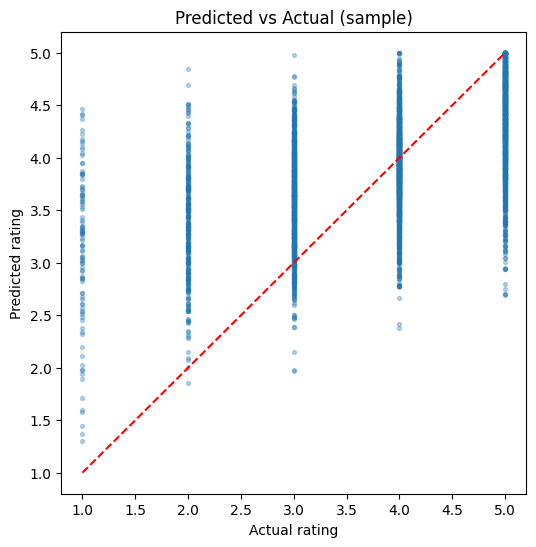

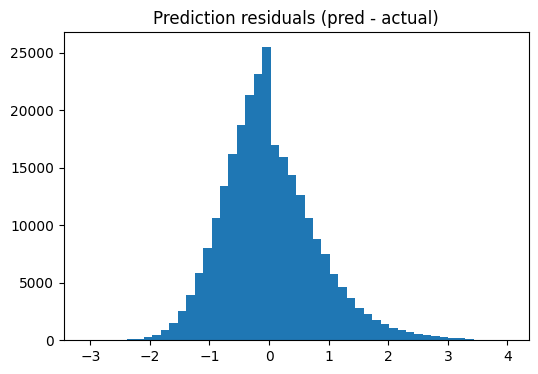

In [52]:
y_true = np.array([p.r_ui for p in predictions])
y_pred = np.array([p.est for p in predictions])
S = 5000
idx = np.random.choice(len(y_true), size=min(S, len(y_true)), replace=False)

plt.figure(figsize=(6,6))
plt.scatter(y_true[idx], y_pred[idx], alpha=0.3, s=8)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')  # y=x line
plt.xlabel("Actual rating")
plt.ylabel("Predicted rating")
plt.title("Predicted vs Actual (sample)")
plt.show()

resid = y_pred - y_true
plt.figure(figsize=(6,4))
plt.hist(resid, bins=50)
plt.title("Prediction residuals (pred - actual)")
plt.show()

In [53]:
train_items_by_user = train_df.groupby('user_id')['book_id'].apply(set).to_dict()
all_items = train_df['book_id'].unique().tolist()  
ITEM_POPULARITY = train_df['book_id'].value_counts()
top_M = 2000  
popular_items = ITEM_POPULARITY.index[:top_M].tolist() if top_M is not None else None

def recommend_top_n_svd(algo, user_id, N=10, candidate_items=None):
    """Return top-N item ids for a user predicted by `algo`.
       candidate_items: list of item ids to consider (if None, uses all_items).
    """
    if candidate_items is None:
        candidate_items = all_items
    rated = train_items_by_user.get(user_id, set())
    candidates = [i for i in candidate_items if i not in rated]
    preds = [(iid, algo.predict(user_id, iid).est) for iid in candidates]
    preds.sort(key=lambda x: x[1], reverse=True)
    return [iid for iid, _ in preds[:N]]

In [54]:
def precision_recall_at_k_svd(test_df, algo, N=10, candidate_items=None):
    precisions, recalls = [], []
    users_in_test = test_df['user_id'].unique()
    for user in tqdm(users_in_test, desc="Evaluating users", unit="user", total=len(users_in_test)):
        relevant = set(test_df.loc[test_df['user_id'] == user, 'book_id'].values)
        if not relevant:
            continue
        recs = set(recommend_top_n_svd(algo, user, N=N, candidate_items=candidate_items))
        hits = recs & relevant
        precisions.append(len(hits) / N)
        recalls.append(len(hits) / len(relevant))
    return np.mean(precisions), np.mean(recalls)

precision, recall = precision_recall_at_k_svd(test_df, algo, N=10, candidate_items=popular_items)
print(f"Top-10 Recommendation → Precision@10: {precision:.4f}, Recall@10: {recall:.4f}")

Evaluating users: 100%|██████████| 53424/53424 [08:28<00:00, 104.96user/s]

Top-10 Recommendation → Precision@10: 0.0121, Recall@10: 0.0242


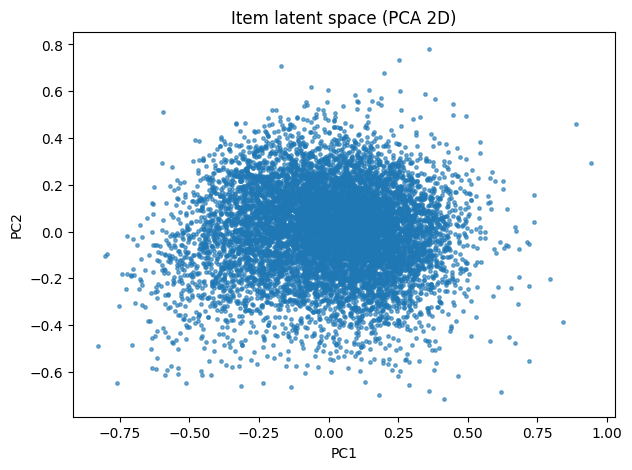

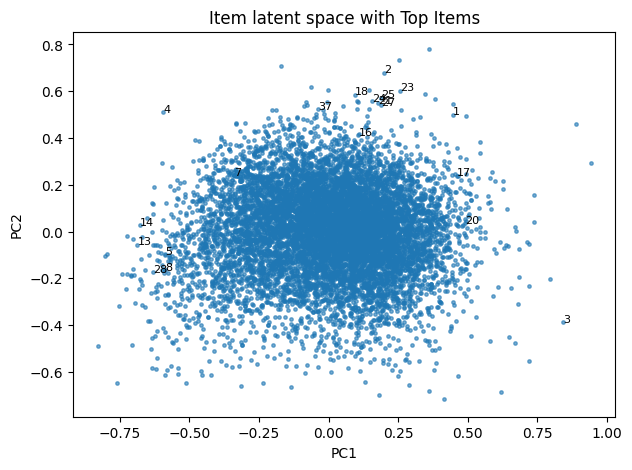

In [55]:
user_factors = algo.pu
item_factors = algo.qi
trainset = algo.trainset

inner_to_raw_user = {i: trainset.to_raw_uid(i) for i in range(trainset.n_users)}
inner_to_raw_item = {i: trainset.to_raw_iid(i) for i in range(trainset.n_items)}
pca = PCA(n_components=2, random_state=RANDOM_STATE)
item_2d = pca.fit_transform(item_factors)
plt.figure(figsize=(7,5))
plt.scatter(item_2d[:,0], item_2d[:,1], s=6, alpha=0.6)
plt.title("Item latent space (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()
top_items = ITEM_POPULARITY.index[:20].tolist()
top_inner_ids = []
for raw_id in top_items:
    try:
        inner_id = trainset.to_inner_iid(raw_id)
        top_inner_ids.append(inner_id)
    except ValueError:
        continue
plt.figure(figsize=(7,5))
plt.scatter(item_2d[:,0], item_2d[:,1], s=6, alpha=0.6)
for iid in top_inner_ids:
    x, y = item_2d[iid]
    plt.text(x, y, trainset.to_raw_iid(iid), fontsize=8)
plt.title("Item latent space with Top Items")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [56]:
test_df_surprise = pd.DataFrame(testset, columns=['user_id', 'book_id', 'rating'])

n_users = test_df_surprise['user_id'].nunique()
n_items = test_df_surprise['book_id'].nunique()
test_items_per_user = test_df_surprise.groupby('user_id')['book_id'].count().values
avg_test_items = np.mean(test_items_per_user)
k = 10
expected_precision = np.mean([min(k, n)/k for n in test_items_per_user])
expected_recall = np.mean([min(k, n)/n for n in test_items_per_user])

print(f"Dataset baseline (random top-{k}):")
print(f"Expected Precision@{k}: {expected_precision:.4f}")
print(f"Expected Recall@{k}: {expected_recall:.4f}")
print(f"Average number of test items per user: {avg_test_items:.2f}")

Dataset baseline (random top-10):
Expected Precision@10: 0.5000
Expected Recall@10: 1.0000
Average number of test items per user: 5.00


In [57]:
k = 10
n_items_total = test_df['book_id'].nunique()

precision_list = []
recall_list = []

for user_id, group in test_df.groupby('user_id'):
    n_relevant = len(group)
    recommended = np.random.choice(n_items_total, k, replace=False)
    relevant_items = group['book_id'].values
    hits = len(set(recommended) & set(relevant_items))
    
    precision_list.append(hits / k)
    recall_list.append(hits / n_relevant)

print(f"Random baseline Precision@{k}: {np.mean(precision_list):.4f}")
print(f"Random baseline Recall@{k}: {np.mean(recall_list):.4f}")
print(f"Average test items per user: {np.mean([len(g) for _, g in test_df.groupby('user_id')]):.2f}")

Random baseline Precision@10: 0.0005
Random baseline Recall@10: 0.0011
Average test items per user: 5.00
